In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = 'data_nutri_score.xlsx'
data = pd.read_excel(file_path)

thresholds = [0.5, 0.6, 0.7]
weights = {
    "Energy (kcal)": 0.4,
    "Sugars (g)": 0.3,
    "Saturated Fat (g)": 0.3,
    "Salt (g)": 0.3,
    "Proteins (g)": 0.2,
    "Fiber (g)": 0.2,
    "Fruits/Vegetables (%)": 0.1
}

profiles = {
    "A": {"Energy (kcal)": 335, "Sugars (g)": 5, "Saturated Fat (g)": 1, "Salt (g)": 0.1, "Proteins (g)": 8, "Fiber (g)": 10, "Fruits/Vegetables (%)": 40},
    "B": {"Energy (kcal)": 400, "Sugars (g)": 10, "Saturated Fat (g)": 2, "Salt (g)": 0.3, "Proteins (g)": 6, "Fiber (g)": 8, "Fruits/Vegetables (%)": 20},
    "C": {"Energy (kcal)": 500, "Sugars (g)": 15, "Saturated Fat (g)": 3, "Salt (g)": 0.5, "Proteins (g)": 4, "Fiber (g)": 5, "Fruits/Vegetables (%)": 10},
    "D": {"Energy (kcal)": 700, "Sugars (g)": 20, "Saturated Fat (g)": 5, "Salt (g)": 1.0, "Proteins (g)": 2, "Fiber (g)": 3, "Fruits/Vegetables (%)": 5},
    "E": {"Energy (kcal)": 900, "Sugars (g)": 30, "Saturated Fat (g)": 8, "Salt (g)": 2.0, "Proteins (g)": 0, "Fiber (g)": 0, "Fruits/Vegetables (%)": 0},
}

# Concordance and Transformation Functions
def compute_concordance(item, profile, weights):
    transformed_item = transform_criteria(item)
    concordance = 0
    total_weight = sum(weights.values())
    for criterion, weight in weights.items():
        if criterion in profile:
            if criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:  # Maximized
                concordance += weight if transformed_item[criterion] >= profile[criterion] else 0
            else:  # Minimized
                concordance += weight if transformed_item[criterion] <= profile[criterion] else 0
    return concordance / total_weight

def transform_criteria(row):
    transformed_row = {}
    for criterion, value in row.items():
        if criterion in ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]:
            transformed_row[criterion] = 10 - (value / max(row.get(criterion, 1), 1))
        elif criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:
            transformed_row[criterion] = value / max(row.get(criterion, 1), 1) * 10
    return transformed_row


def optimistic_majority_sorting(item, profiles, weights, lambda_threshold):
    """
    Assign an optimistic category based on the concordance score and threshold.
    """
    for category, profile in profiles.items():
        concordance = compute_concordance(item, profile, weights)
        if concordance >= lambda_threshold:
            return category
    return "E"

results = []
for _, row in data.iterrows():
    product_info = row.to_dict()
    for lambda_value in thresholds:
        category = optimistic_majority_sorting(product_info, profiles, weights, lambda_value)
        results.append({
            "Product Name": product_info["Product Name"], "Nutri-Score": product_info.get("Nutri-Score", "").upper(),
            "Optimistic": category,
            "Lambda": lambda_value,
        })

results_df = pd.DataFrame(results)
results_df

,Product Name,Nutri-Score,Optimistic,Lambda
0,cruesly mélange de noix,A,B,0.5
1,cruesly mélange de noix,A,B,0.6
2,cruesly mélange de noix,A,E,0.7
3,Céréales Chocapic,A,B,0.5
4,Céréales Chocapic,A,B,0.6
...,...,...,...,...
2824,Bamboo,A,B,0.6
2825,Bamboo,A,E,0.7
2826,Müesli croccante all'avena,C,B,0.5
2827,Müesli croccante all'avena,C,B,0.6


## Cluster Analysis Method - Kmeans

In [3]:
from sklearn.cluster import KMeans

In [4]:
data = pd.read_excel("data_nutri_score.xlsx") 

# Select relevant columns for clustering
columns_to_use = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)", 
                  "Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]

# Prepare data for clustering
clustering_data = data[columns_to_use].dropna()

# Apply KMeans clustering to determine 5 clusters (Nutri-Score categories: A to E)
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(clustering_data)

# Extract centroids as limiting profiles
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=columns_to_use)

# Map cluster numbers to Nutri-Score labels (A to E based on centroids' order)
cluster_to_label = {i: label for i, label in enumerate(sorted(['A', 'B', 'C', 'D', 'E'], reverse=True))}
centroids['Nutri-Score'] = centroids.index.map(cluster_to_label)

# Save centroids as limiting profiles
centroids_output_file = "Cluster_Limiting_Profiles.xlsx"
centroids.to_excel(centroids_output_file, index_label="Cluster")

# Print limiting profiles for inspection
print("Limiting profiles derived from clusters:")
centroids

Limiting profiles derived from clusters:


,Energy (kcal),Sugars (g),Saturated Fat (g),Salt (g),Proteins (g),Fiber (g),Fruits/Vegetables (%),Nutri-Score
0,374.109269,12.247907,1.173311,0.362684,10.233188,8.249171,5.256934,E
1,213.000000,7.866667,1.966667,0.260000,6.500000,5.766667,7.518136,D
2,466.003286,17.544085,4.853713,0.277018,9.734885,7.494956,9.344656,C
3,426.291030,19.060652,3.043512,0.325902,9.870209,7.200275,8.114808,B
4,0.000000,10.040000,1.050000,0.250500,6.700000,9.020000,6.359783,A


In [5]:
# retrieved and structured centroids as limiting profiles
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=columns_to_use)

# maping cluster numbers to Nutri-Score categories (A to E)
centroids['Nutri-Score'] = centroids['Fruits/Vegetables (%)'].rank(ascending=False).astype(int).map({
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E'
})

# converting centroids to limiting profiles
limiting_profiles = {
    row['Nutri-Score']: row[columns_to_use].to_dict()
    for _, row in centroids.iterrows()
}

print("Dynamic Limiting Profiles:")
for category, profile in limiting_profiles.items():
    print(f"\nCategory: {category}")
    for criterion, value in profile.items():
        print(f"  {criterion}: {value:.2f}")

Dynamic Limiting Profiles:

Category: E
  Energy (kcal): 374.11
  Sugars (g): 12.25
  Saturated Fat (g): 1.17
  Salt (g): 0.36
  Proteins (g): 10.23
  Fiber (g): 8.25
  Fruits/Vegetables (%): 5.26

Category: C
  Energy (kcal): 213.00
  Sugars (g): 7.87
  Saturated Fat (g): 1.97
  Salt (g): 0.26
  Proteins (g): 6.50
  Fiber (g): 5.77
  Fruits/Vegetables (%): 7.52

Category: A
  Energy (kcal): 466.00
  Sugars (g): 17.54
  Saturated Fat (g): 4.85
  Salt (g): 0.28
  Proteins (g): 9.73
  Fiber (g): 7.49
  Fruits/Vegetables (%): 9.34

Category: B
  Energy (kcal): 426.29
  Sugars (g): 19.06
  Saturated Fat (g): 3.04
  Salt (g): 0.33
  Proteins (g): 9.87
  Fiber (g): 7.20
  Fruits/Vegetables (%): 8.11

Category: D
  Energy (kcal): 0.00
  Sugars (g): 10.04
  Saturated Fat (g): 1.05
  Salt (g): 0.25
  Proteins (g): 6.70
  Fiber (g): 9.02
  Fruits/Vegetables (%): 6.36


In [6]:
df_limit_profiles = pd.DataFrame(limiting_profiles)
df_limit_profiles

,E,C,A,B,D
Energy (kcal),374.109269,213.000000,466.003286,426.291030,0.000000
Sugars (g),12.247907,7.866667,17.544085,19.060652,10.040000
Saturated Fat (g),1.173311,1.966667,4.853713,3.043512,1.050000
Salt (g),0.362684,0.260000,0.277018,0.325902,0.250500
Proteins (g),10.233188,6.500000,9.734885,9.870209,6.700000
Fiber (g),8.249171,5.766667,7.494956,7.200275,9.020000
Fruits/Vegetables (%),5.256934,7.518136,9.344656,8.114808,6.359783


In [7]:
# Assuming `limiting_profiles` is derived from cluster centroids
data = pd.read_excel("data_nutri_score.xlsx")

results_optimistic = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        # Classify using optimistic sorting and dynamic limiting profiles
        optimistic_category_cluster = optimistic_majority_sorting(row, limiting_profiles, weights, lambda_value)

        results_optimistic.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"],
            "Optimistic Category": optimistic_category_cluster,
            "Lambda": lambda_value,
        })

# Create a DataFrame to store results
df_optimistic = pd.DataFrame(results_optimistic)
df_optimistic

,Product Name,Nutri score,Optimistic Category,Lambda
0,cruesly mélange de noix,a,E,0.5
1,cruesly mélange de noix,a,A,0.6
2,cruesly mélange de noix,a,E,0.7
3,Céréales Chocapic,a,A,0.5
4,Céréales Chocapic,a,A,0.6
...,...,...,...,...
2824,Bamboo,a,A,0.6
2825,Bamboo,a,E,0.7
2826,Müesli croccante all'avena,c,E,0.5
2827,Müesli croccante all'avena,c,A,0.6


In [8]:
# Save the results to an Excel file
df_optimistic.to_excel("Optimistic_Nutri_Score_Cluster_Analysis.xlsx", index=False)

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Labels used for confusion matrix: ['A', 'B', 'C', 'D', 'E']


/var/folders/zx/h1j27ppn3kq1md12x3h7xf3r0000gn/T/ipykernel_3491/1224760894.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Nutri score"] = subset["Nutri score"].str.strip().str.upper()
/var/folders/zx/h1j27ppn3kq1md12x3h7xf3r0000gn/T/ipykernel_3491/1224760894.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Optimistic Category"] = subset["Optimistic Category"].str.strip().str.upper()


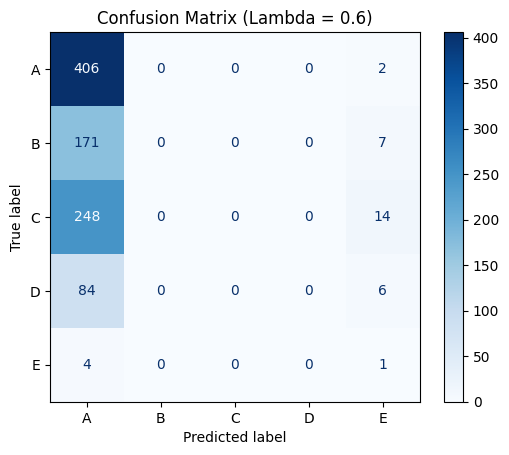

In [11]:
lambda_to_analyze = 0.6

# Filter the subset
subset = df_optimistic[df_optimistic["Lambda"] == lambda_to_analyze]

# Ensure labels are clean
subset["Nutri score"] = subset["Nutri score"].str.strip().str.upper()
subset["Optimistic Category"] = subset["Optimistic Category"].str.strip().str.upper()

# Check unique labels
y_true = subset["Nutri score"]
y_pred = subset["Optimistic Category"]

# Handle dynamically identified labels
unique_labels = sorted(set(y_true.unique()) | set(y_pred.unique()))  # Union of labels
print(f"Labels used for confusion matrix: {unique_labels}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()